In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re

In [2]:
documnets = [
    "This little kitty came to play when I was eating at a resturaunt.",
    "Merley has the best squooshy kitten belly.",
    "Google Translate app is incredible.",
    "If you open 100 tab in google you get ad smiley face.",
    "Best cat photo I;ve ever taken.",
    "Climbing ninja cat.",
    "Impressed with google map feedback.",
    "Key promoter extension for Google Chrome.",    
]

In [3]:
from collections import defaultdict
# DTM -> TDM -> TWM
DTM = defaultdict(lambda:defaultdict(int))
for i, d in enumerate(documnets):
    for t in word_tokenize(d.lower()):
        if t not in stopwords.words("english") and \
            not re.search(r"[%s]" % re.escape(punctuation), t):
                DTM[i][t] += 1

In [4]:
len(DTM), DTM[0]

(8,
 defaultdict(int,
             {'little': 1,
              'kitty': 1,
              'came': 1,
              'play': 1,
              'eating': 1,
              'resturaunt': 1}))

In [5]:
TDM = defaultdict(lambda:defaultdict(int))
for d, termList in DTM.items():
    for t, f in termList.items():
        TDM[t][d] = f

In [6]:
len(TDM)

35

### TF * IDF
### TF = freq(i, j) / max freq(j) => j번째 문서에서 나온, i번째의 빈도를 freq(i, j)
### freq(i, j) => TDM[단어][문서:빈도], max freq => DTM[문서]max([단어:빈도])
### IDF = log N/df(i) => i번째 단어의 문서빈도 df(i), N => 전체문서수 
### df => len(TDM[단어]), N => len(DTM)

In [7]:
from math import log2

TWM = defaultdict(lambda:defaultdict(float))
# TWM[단어][문서:가중치....]
N = len(DTM)
for term, docList in TDM.items():
    df = len(docList)
    for d, f in docList.items():
        maxFreq = max(DTM[d].values())
        TF = f/maxFreq
        IDF = log2(N/df)
        TWM[term][d] = TF * IDF
# TWM[단어][문서:가중치, ... ]

### TWM => 단어 - 문서 : 가중치
### 단어 -> concept(차원, 축), 문서 -> BOW(단어, 단어 단어,) V = TDM.keys()
### 문서1 = [0, 0, 0, 1, ... V] 
### 문서2 = [1, 0, 0, 1, ... V]

In [8]:
docVectorList = [[0 for _ in range(len(TDM))] for _ in range(N)]

D = list(DTM.keys())
V = list(TDM.keys())

for t, docList in TWM.items():
    for d, w in docList.items():
        docVectorList[D.index(d)][V.index(t)] = w
print(docVectorList[0])
print(D[0], V[:6])

[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 ['little', 'kitty', 'came', 'play', 'eating', 'resturaunt']


In [10]:
len(docVectorList), len(documnets), len(docVectorList[0]), len(TDM)

(8, 8, 35, 35)

In [41]:
from math import sqrt

def distance(x1, x2):
    _sum = 0
    for i in range(len(x1)):
        _sum += (x1[i] - x2[i])**2
    return sqrt(_sum)
#     return sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2)

def angle(x1, x2):
    _innerProduct = 0
    for i in range(len(x1)):
        _innerProduct += x1[i] * x2[i]
    x1VecLength = distance(x1, [0 for _ in range(len(x1))]) + 0.1
    x2VecLength = distance(x2, [0 for _ in range(len(x2))]) + 0.1
    return _innerProduct/(x1VecLength * x2VecLength)
#     return (x1[0] * x2[0] + x1[1] * x2[1]) / (distance(x1, (0,0)) * distance(x2, (0,0)))
    

In [12]:
def expectation(x, c, opt=False):

    candidates = list()
    nearest = distance if not opt else angle
    best = min if not opt else max

    for _ in c:
        candidates.append(nearest(x, _))
    return candidates.index(best(candidates)) # 클러스터 번호

In [13]:
def maximization(X, lenV):
    _sum = [0 for _ in range(len(X[0]))]
    D = len(X)
    
    for x in X:
        for i in range(len(x)):
            _sum[i] += x[i]           
    return [_/D for _ in _sum]

In [14]:
def sumSquaredError(X, c, opt=False):
    
    nearest = distance if not opt else angle
    
    error = 0
    for x in X:
        error += nearest(x, c)
    return error 

In [15]:
from random import randrange
K = 2

# V 차원
centroid = [[randrange(0, 4) for _ in range(len(V))] for _ in range(K)]
_iter = 10
seeList = list()

for _ in range(_iter):
    rnk = list(list(0 for _ in range(K)) for _ in range(N))
    
    for i, x in enumerate(docVectorList):
        idx = expectation(x, centroid)
        rnk[i][idx] = 1
    _sum = 0.0
    for k in range(K):
        _X = [docVectorList[i] for i in range(N) if rnk[i][k]]
        _sum = sumSquaredError(_X, centroid[k])
        centroid[k] = maximization(_X, len(V))
    seeList.append(_sum)

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(_iter), seeList, "r-")
plt.show()

<Figure size 640x480 with 1 Axes>

In [17]:
for k in range(K):
    _X = [i for i in range(len(D)) if rnk[i][k]]
    print("Cluster :", k)
    for x in _X:
        print(documnets[x])

Cluster : 0
Merley has the best squooshy kitten belly.
Key promoter extension for Google Chrome.
Cluster : 1
This little kitty came to play when I was eating at a resturaunt.
Google Translate app is incredible.
If you open 100 tab in google you get ad smiley face.
Best cat photo I;ve ever taken.
Climbing ninja cat.
Impressed with google map feedback.


### 토픽(centroid) 찾기

In [18]:
result = list()
for k in range(K):
    W = [(V[i], centroid[k][i]) for i in range(len(V))
         if centroid[k][i]]
    result.append(sorted(W, key=lambda x:x[1], reverse=True)[:5])
#     print(sorted(W, key=lambda x:x[1], reverse=True)[:5])

In [19]:
result

[[('merley', 1.5),
  ('squooshy', 1.5),
  ('kitten', 1.5),
  ('belly', 1.5),
  ('key', 1.5)],
 [('cat', 0.6666666666666666),
  ('little', 0.5),
  ('kitty', 0.5),
  ('came', 0.5),
  ('play', 0.5)]]

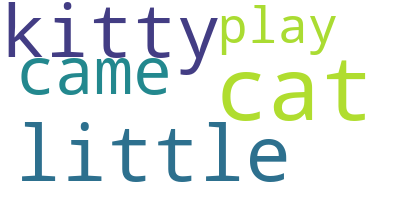

In [20]:
from wordcloud import WordCloud

data = {x[0]:x[1] for x in result[1]}

wc = WordCloud(background_color="white")
wc.generate_from_frequencies(data)
wc.to_image()

# 뉴스카테고리별로 토픽 끄내기
# V = [len(V)] => 명사(2음절 이상)
# K = 6

In [21]:
# 토픽: 적절한 설명
from random import sample
len(sample(docVectorList, K))

2

In [22]:
from os import listdir
def fileids(path):
    return [path+file for file in listdir(path)]

In [23]:
def filecontent(file):
    with open(file, encoding='utf-8') as fp:
        content = fp.read()
    return content

In [24]:
from string import punctuation
import re

def makePattern():
    pattern = dict()

    # 구두점
    pattern1 = re.compile(r'[{0}]'.format(re.escape(punctuation)))
    pattern['punc'] = pattern1
    # corpus = pattern1.sub(' ',corpus)

    # 불용어
    pattern2 = re.compile(r'[A-Za-z0-9]{7,}')
    pattern['stop'] = pattern2
    # corpus = pattern2.sub(' ',corpus)

    # 이메일
    # pattern3 = re.compile(r'\w{2,}@\w{3,}(.\w{2,})+')
    pattern3 = re.compile(r'\w{2,}@(.?\w{2,})+')
    pattern['email'] = pattern3
    # corpus = pattern3.sub(' ',corpus)

    # 도메인
    pattern4 = re.compile(r'(.?\w{2,}){2,}')
    pattern['url'] = pattern4
    # corpus = pattern4.sub(' ',corpus)

    # 한글 이외
    pattern5 = re.compile(r'[^가-힣0-9]+')
    pattern['nonkorean'] = pattern5
    # corpus = pattern5.sub(' ',corpus)

    # WhiteSpace
    pattern6 = re.compile(r"\s{2,}")
    pattern['whitespace'] = pattern5
    # corpus = pattern6.sub(' ',corpus)
    
    return pattern

In [25]:
from collections import defaultdict

# content = filecontent(fileids('./news_crawl_project/')[-2])

pattern = makePattern()

def punc_stop(file):
    for _ in ['email', 'punc', 'stop','whitespace']:
        file = pattern[_].sub(' ',file)
    return file

def indexing(file):
    indexTerm1 = defaultdict(int)
    indexTerm4 = defaultdict(int)

    for term in word_tokenize(file):
        indexTerm1[term] += 1 # 원시어절
    
    for _ in indexTerm1:
        for t in ma.pos(_):
            if t[1].startswith('N') and len(t[0]) >= 2:
                indexTerm4[t[0]] += 1 # 명사
           
    return indexTerm4 #일단은 명사만 

In [26]:
from konlpy.tag import Komoran

ma = Komoran()

def DTM_conversion():
    documentList = defaultdict(lambda: defaultdict(int))
    idx = 0
    for file in fileids('./news_crawl_project/'):
        documentList[idx] = indexing(punc_stop(filecontent(file)))
        idx += 1
        if idx % 100 == 0:
            print(idx, '진행중')
    return documentList
DTM = DTM_conversion()

100 진행중
200 진행중
300 진행중
400 진행중
500 진행중
600 진행중
700 진행중
800 진행중
900 진행중
1000 진행중
1100 진행중
1200 진행중


In [27]:
len(DTM)

1252

In [28]:
TDM = defaultdict(lambda:defaultdict(int))
for d, termList in DTM.items():
    for t, f in termList.items():
        TDM[t][d] = f

In [34]:
len(TDM), TDM['의회']

(16825,
 defaultdict(int,
             {45: 1,
              190: 1,
              232: 2,
              418: 1,
              514: 1,
              519: 1,
              526: 2,
              531: 2,
              550: 1,
              559: 1,
              578: 1,
              773: 1,
              1008: 3,
              1010: 4,
              1011: 3,
              1012: 3,
              1014: 2,
              1021: 3,
              1132: 1,
              1137: 3,
              1157: 3}))

In [30]:
from math import log2

TWM = defaultdict(lambda:defaultdict(float))
# TWM[단어][문서:가중치....]
N = len(DTM)
for term, docList in TDM.items():
    df = len(docList)
    for d, f in docList.items():
        maxFreq = max(DTM[d].values())
        TF = f/maxFreq
        IDF = log2(N/df)
        TWM[term][d] = TF * IDF
# TWM[단어][문서:가중치, ... ]

In [31]:
docVectorList = [[0 for _ in range(len(TDM))] for _ in range(N)]

D = list(DTM.keys())
V = list(TDM.keys())

for t, docList in TWM.items():
    for d, w in docList.items():
        docVectorList[D.index(d)][V.index(t)] = w

In [35]:
print(len(docVectorList[0]), len(V), len(D), N)
# print(D[0], V[:6])

16825 16825 1252 1252


In [52]:
from random import randrange

K = 6
# V 차원
centroid = sample(docVectorList, K)
_iter = 4
seeList = list()

for _ in range(_iter):
    
    rnk = list(list(0 for _ in range(K)) for _ in range(N))
    
    for i, x in enumerate(docVectorList):
        idx = expectation(x, centroid, True)
        rnk[i][idx] = 1
    
    _sum = 0.0
    
    for k in range(K):
        _X = [docVectorList[i] for i in range(N) if rnk[i][k]]
        _sum = sumSquaredError(_X, centroid[k], True)
        centroid[k] = maximization(_X, len(V))
    seeList.append(_sum)

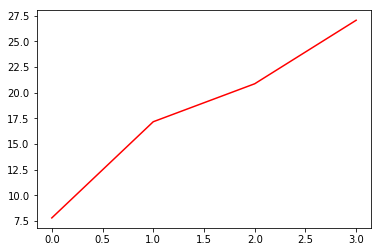

In [53]:
import matplotlib.pyplot as plt

plt.plot(range(_iter), seeList, "r-")
plt.show()

In [54]:
result = list()
for k in range(K):
    W = [(V[i], centroid[k][i]) for i in range(len(V))
         if centroid[k][i]]
    result.append(sorted(W, key=lambda x:x[1], reverse=True)[:10])
#     print(sorted(W, key=lambda x:x[1], reverse=True)[:5])

In [55]:
result

[[('관세', 0.6474009756646407),
  ('버스', 0.6086327937910561),
  ('인상', 0.592928353616887),
  ('중국', 0.5624230516501608),
  ('무역', 0.5614536587840893),
  ('협상', 0.5316712659428753),
  ('달러', 0.45920931022430306),
  ('미국', 0.41754344892979184),
  ('파업', 0.4080675701246289),
  ('노조', 0.3879286919730207)],
 [('원내대표', 0.38109970242666263),
  ('한국당', 0.30326127534538033),
  ('대표', 0.30240625814578076),
  ('의원', 0.29386258547818295),
  ('국회', 0.25665434905856005),
  ('대통령', 0.2477529770235342),
  ('사용', 0.2390174884238973),
  ('협의체', 0.23531287564285788),
  ('회담', 0.22371783608188536),
  ('여야', 0.21803815434747034)],
 [('제출', 0.5416481230662259),
  ('가족', 0.5339610977751443),
  ('지분', 0.5324869287565182),
  ('회장', 0.5003005467159004),
  ('상속', 0.4984867433816201),
  ('사고', 0.49744205992944024),
  ('한진그룹', 0.46537816495255635),
  ('동일인', 0.4423870888492427),
  ('어머니', 0.4199080465338452),
  ('공정위', 0.40625817338572473)],
 [('부르키나파소', 0.791634823056729),
  ('무장', 0.7181802635575096),
  ('납치', 0.7

In [56]:
from wordcloud import WordCloud

font = "c:/Windows/Fonts/NanumGothic.ttf"
image_list= list()
for i in range(K):
    data = {x[0]:x[1] for x in result[i]}
    wc = WordCloud(font, background_color="white")
    wc.generate_from_frequencies(data)
#     plt.title(centroid[i])
#     plt.imshow(wc.to_image())
    image_list.append(wc.to_image())

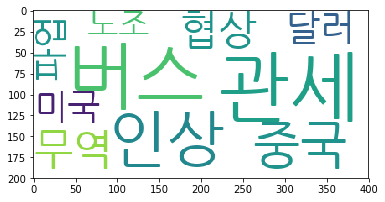

In [57]:
plt.imshow(image_list[0])

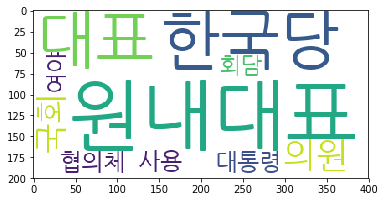

In [58]:
plt.imshow(image_list[1])

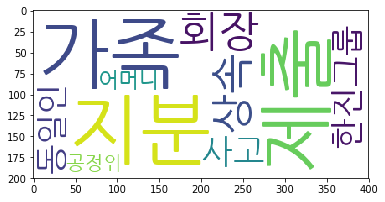

In [59]:
plt.imshow(image_list[2])

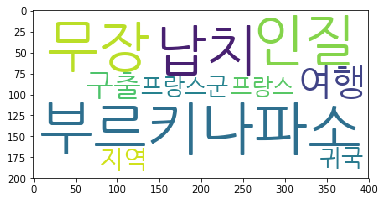

In [60]:
plt.imshow(image_list[3])

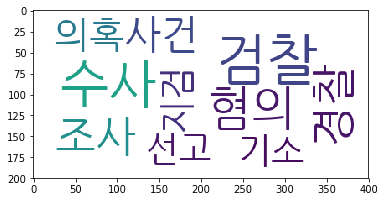

In [61]:
plt.imshow(image_list[4])

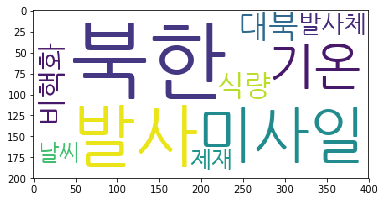

In [62]:
plt.imshow(image_list[5])